In [1]:
%reload_ext autoreload

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from quantum_tools.contexts.quantum_caller import *
from quantum_tools.statistics import *
from quantum_tools.examples.symbolic_contexts import *
from quantum_tools.examples.prob_dists import *
from quantum_tools.rmt.unitary_param import *
from quantum_tools.rmt.utils import *
from quantum_tools.utilities import utils
from quantum_tools.statistics.probability import *
from quantum_tools.visualization.transversal_inequalities import *
from quantum_tools.config import *
from quantum_tools.inflation import marginal_equality
from itertools import permutations
import numpy as np
from scipy import optimize
from quantum_tools.visualization.triangle_plot import *
import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = False

In [24]:
result_backlog = []

def minimize_callback(f):
    logged_results = []
    print(len(result_backlog))
    result_backlog.append(logged_results)
    def _callback(x, *args, **kwargs):
        result = f(x)
#         print(result)
        print(result, end='\r')
        logged_results.append(result)
    return _callback

def stochastic_jump(x, scale_std=0.001):
    norm_x = np.linalg.norm(x)
    delta_x = np.random.normal(0.0, norm_x * scale_std, x.shape)
    return x + delta_x

def plot_gd(h_f):
    plt.figure()
    plt.xlabel('Gradient Descent Step')
    plt.ylabel('Inequality Target')
    plt.title('Violations')
    plt.plot(np.arange(len(h_f)), h_f)
    # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    plt.axis([0, len(h_f), h_f.min(), h_f.max()])
    plt.grid(True)
    plt.show()
    
def plot_results(results):
    results = np.asarray(results)
    plt.figure()
    plt.xlabel('Step')
    plt.ylabel('Inequality Target')
    plt.title('Minimize Results')
    plt.plot(np.arange(len(results)), results)
    # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    plt.axis([0, len(results), results.min(), results.max()])
    plt.grid(True)
    plt.show()

In [5]:
def CHSH_Target(pds):
    pd1, pd2, pd3, pd4 = pds
    return -(pd1.correlation(('A', 'B')) + pd2.correlation(('A', 'B')) + pd3.correlation(('A', 'B')) - pd4.correlation(('A', 'B')))

In [6]:
rvc = RandomVariableCollection.new(('A', 'B'), (2,2))

def convex_dist(rvc, param):
    param = param.copy()
    param = np.abs(param)
    param /= np.sum(param)
    param = param.reshape(rvc.outcome_space.get_input_base())
    return ProbDist(rvc, param)
    
def convex_seed(rvc):
    return np.random.uniform(0,1,4*len(rvc.outcome_space))

class CHSHConvexityCaller(ParamCaller):
    
    def __init__(self):
        super().__init__(CHSH_Target, [4, 4, 4, 4])
        self.rvc = rvc
        
    def context(self, param):
        return tuple(convex_dist(self.rvc, param[self.slots[i]]) for i in range(4))

In [30]:
f = CHSHConvexityCaller()
x0 = convex_seed(rvc)
optimize.minimize(f, x0, tol=0.00001, callback=minimize_callback(f))

5


  message: 'Desired error not necessarily achieved due to precision loss.'
 hess_inv: array([[ 1.14386,  0.     ,  0.     ,  0.14386,  0.14856,  0.     , -0.     ,  0.14856,  0.12937,  0.     ,  0.     ,
         0.12937,  0.     ,  0.1279 ,  0.1279 , -0.     ],
       [ 0.     ,  0.     , -0.     , -0.     ,  0.     , -0.     , -0.     ,  0.     , -0.     , -0.     ,  0.     ,
         0.     ,  0.     , -0.     , -0.     ,  0.     ],
       [ 0.     , -0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     , -0.     , -0.     ,
         0.     ,  0.     ,  0.     ,  0.     , -0.     ],
       [ 0.14386, -0.     ,  0.     ,  1.14386,  0.14856,  0.     , -0.     ,  0.14856,  0.12937,  0.     ,  0.     ,
         0.12937,  0.     ,  0.1279 ,  0.1279 , -0.     ],
       [ 0.14856,  0.     ,  0.     ,  0.14856,  1.14042,  0.     , -0.     ,  0.14042,  0.12739, -0.     ,  0.     ,
         0.12739,  0.     ,  0.12137,  0.12137, -0.     ],
       [ 0.     , -0.     ,  

In [14]:
len(result_backlog)

5

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


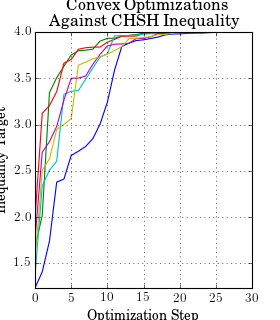

30


In [36]:
result_list = [np.array(result_backlog[i]) * -1 for i in range(len(result_backlog))]
plt.figure()
plt.figure(figsize=(3.5,4))
plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
plt.xlabel(r'Optimization Step')
plt.ylabel(r'Inequality Target')
plt.title(r'Convex Optimizations \\ Against CHSH Inequality')
max_step = -np.inf
min_h = min(result_list[i][0] for i in range(len(result_list)))
max_h = 4
for i in range(len(result_list)):
    j = 0
    while j < len(result_list[i]):
    
        if (4 - result_list[i][j]) < 0.001:
            if j > max_step:
                max_step = j
            break
        j += 1
print(max_step)
for i in range(len(result_list)):
    y = result_list[i][0:max_step]
    plt.plot(np.arange(len(y)), y)
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([0, max_step, min_h, max_h])
plt.grid(True)
plt.savefig(utils.temp_dir('CHSH_convex.pdf'), format='pdf')
plt.show()